This notebook is to be used for the production of figures for the LOXL2 manuscript with Boise State regarding the research into a link between OSM/OSMR and Lysyl Oxidase Like 2. It is written and analyzed by Daniel Greiner.

# Background

The data used in this analysis is downloaded from the TCGA GDAC Firehose. It uses the RSEM RNA-SEQ V2 normalized Level 3 data as provided by TCGA for all 3 datasets (BRCA, GBM, and PRAD).

# Analysis

In [2]:
#BASIC LIBRARY IMPORTS
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plots
import requests
import matplotlib.pyplot as plt
import json
import xml.etree.ElementTree as ET
import csv
import seaborn as sns
import statsmodels.api as smf
from requests import session
from scipy import stats
from scipy.stats import pearsonr
import scipy as sp
%matplotlib inline
plots.style.use('fivethirtyeight')
plots.rcParams['axes.facecolor'] = 'ffffff'
from numpy.polynomial.polynomial import polyfit



In [3]:
#Defined functions
def regression_line(r):
    x = np.random.normal(0, 1, 10000)
    z = np.random.normal(0, 1, 10000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.figure(figsize=(6, 6))
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)
    plots.scatter(x, y)
    plots.plot([-4, 4], [-4*r,4*r], color='g', lw=2)
    if r >= 0:
        plots.plot([-4,4],[-4,4], lw=2, color='r')
    else:
        plots.plot([-4,4], [4,-4], lw=2, color='r')
#Convert array into standard units
def standard_units(xyz):
    "Convert any array of numbers to standard units."
    return (xyz - np.mean(xyz))/np.std(xyz)  
#Determine correlation of two variables
def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))
#Determine slope for 2 variables scatter plot
def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))
#Determine intercept for 2 variable scatter plot
def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))
#Convert alive/dead into 0/1 for lifelines KMF application
def lifestatus(x):
    if x == 'LIVING':
        return '1'
    if x == 'Died of Other Causes':
        return '1'
    else: 
        return '0'
    
#Identification of percentiles for gene of interest
def high_percentile(y,x):
    gene_values = y.column(x)
    high_percentile = np.percentile(gene_values,75)
    return (high_percentile)
def low_percentile(y, x):
    gene_values = y.column(x)
    low_percentile = np.percentile(gene_values,25)
    return (low_percentile)
def gene_tester(x,y,z):
# This script basically allows me to quickly print out a scatter plot 
# x = gene 1
# y = gene 2
# z = database of interest
    return z.scatter(x,y,fit_line=True)
def gene_tester_stats(x,y,z):
# This script basically allows me to quickly print out statistics for correlation
# x = gene 1
# y = gene 2
# z = database of interest
    return (pearsonr(z.column(x),z.column(y)))

First we need to import all of our data:

In [4]:
#Importing normalized RSEM gene expression.
brca_tcga_gene_normalized = pd.read_csv('data/TCGA/gdac.broadinstitute.org_BRCA.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0/BRCA.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt',delimiter="\t", low_memory=False)
prda_tcga_gene_normalized = pd.read_csv('data/TCGA/gdac.broadinstitute.org_PRAD.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0/PRAD.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt',delimiter="\t", low_memory=False)
gbm_tcga_gene_normalized = pd.read_csv('data/TCGA/gdac.broadinstitute.org_GBM.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0/GBM.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt',delimiter="\t", low_memory=False)
ov_tcga_gene_normalized = pd.read_csv('data/TCGA/gdac.broadinstitute.org_OV.Merge_rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.Level_3.2016012800.0.0/OV.rnaseqv2__illuminahiseq_rnaseqv2__unc_edu__Level_3__RSEM_genes_normalized__data.data.txt',delimiter="\t", low_memory=False)

#Importing clinical information
brca_clinical = pd.read_csv('data/TCGA/gdac.broadinstitute.org_BRCA.Clinical_Pick_Tier1.Level_4.2016012800.0.0/All_CDEs.txt', delimiter="\t")
prda_clinical = pd.read_csv('data/TCGA/gdac.broadinstitute.org_PRAD.Clinical_Pick_Tier1.Level_4.2016012800.0.0/All_CDEs.txt', delimiter="\t")
gbc_clinical = pd.read_csv('data/TCGA/gdac.broadinstitute.org_GBM.Clinical_Pick_Tier1.Level_4.2016012800.0.0/All_CDEs.txt', delimiter="\t")


Now, I need to separate the gene ID from the official symbol so that I can effectively search for the value I am looking for.

In [41]:
#brca_tcga_gene_normalized
col_name = []
for col in brca_tcga_gene_normalized: 
    col_name.append(col)
#print(col_name)
del col_name[0]

clean_names = []
for i in col_name:
    x = i[8:-16]
    clean_names.append(x)
print ("Samples",(len(clean_names)))
pat_samples = list(dict.fromkeys(clean_names))
print ("Patient count",(len(pat_samples)))
    

Samples 1212
Patient count 1093


Here, I'll start by comparing OSM / LOXL2

In [1]:
def get_df_name(df):
    """A brief function to get the name of the dataframe being used in the for loop below
    so that we can label the graph as needed."""
    
    name = [x for x in globals() if globals()[x] is df][0]
    return name



datasets = (brca_tcga_gene_normalized,prda_tcga_gene_normalized,gbm_tcga_gene_normalized,ov_tcga_gene_normalized)

gene_of_interest_x = 'OSM'
gene_of_interest_y = 'LOXL2'

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in datasets:
    #Script to get DF name
    name = get_df_name(i)
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == "brca_tcga_gene_normalized":
        data_name = "Breast Invasive Carcinoma"
    if name == "prda_tcga_gene_normalized":
        data_name = "Prostate Adenocarcinoma"
    if name == "gbm_tcga_gene_normalized":
        data_name = "Glioblastoma Multiforme"
    if name == "ov_tcga_gene_normalized":
        data_name = "Ovarian serous cystadenocarcinoma"
    
    
    #Next, i'm running my gene selection
    x = (i['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    i['genelist'] = x
        
    gene_selectx = i.loc[i['genelist'] == gene_of_interest_x]
    gene_selecty = i.loc[i['genelist'] == gene_of_interest_y]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    
    print('Y = ',fitted.params[1],'X',fitted.params[0])
    
    # the estimated parameters for the regression line
    print(fitted.summary())

plt.tick_params(labelsize=28)
plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/TCGA_dataset_osm_v_loxl2.png')
plt.show()


NameError: name 'brca_tcga_gene_normalized' is not defined

# Next, without the legend as requested by Simion Dinca.

Samples 1158
Patient count 1044
Breast Invasive Carcinoma Pearson Coefficient: (0.13908981612338026, 2.022703186230283e-06)
[-0.08641578  0.14163125]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     22.81
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           2.02e-06
Time:                        13:29:13   Log-Likelihood:                -1219.0
No. Observations:                1158   AIC:                             2442.
Df Residuals:                    1156   BIC:                             2452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

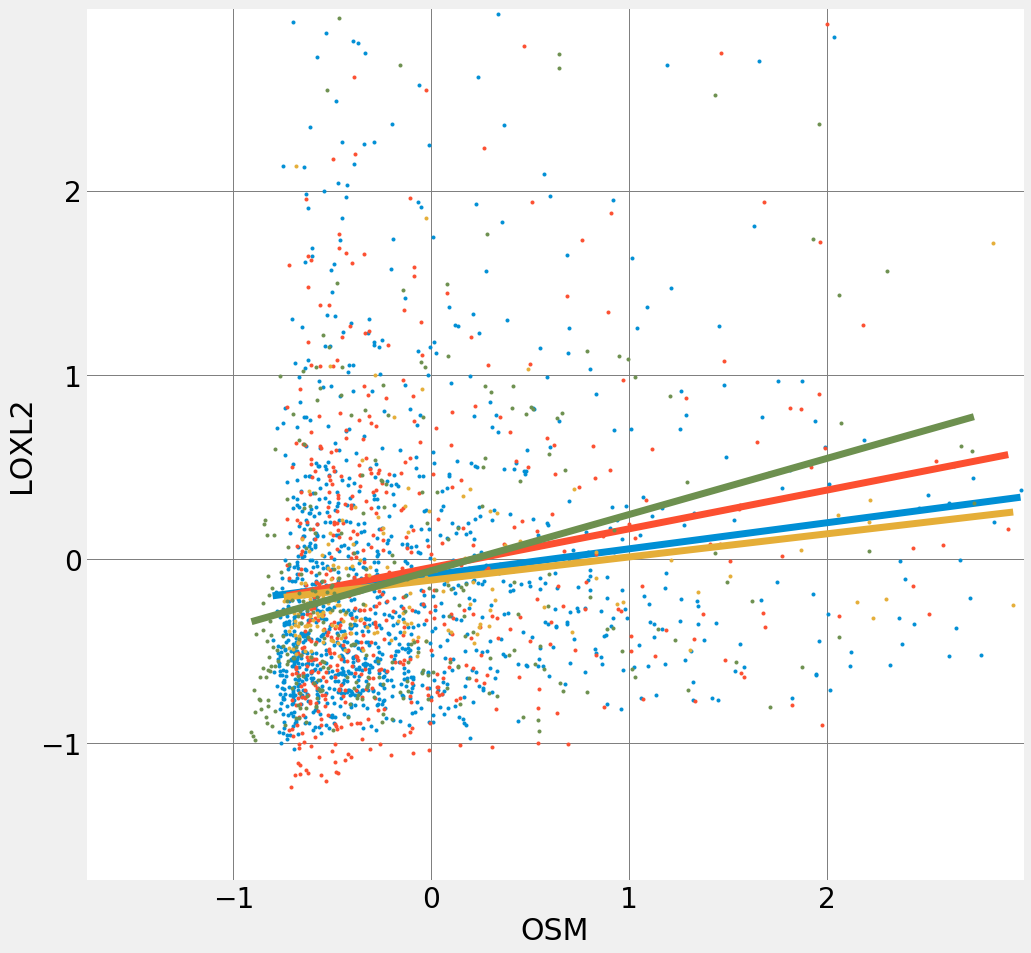

In [26]:
def get_df_name(df):
    """A brief function to get the name of the dataframe being used in the for loop below
    so that we can label the graph as needed."""
    
    name = [x for x in globals() if globals()[x] is df][0]
    return name



datasets = (brca_tcga_gene_normalized,prda_tcga_gene_normalized,gbm_tcga_gene_normalized,ov_tcga_gene_normalized)

gene_of_interest_x = 'OSM'
gene_of_interest_y = 'LOXL2'

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in datasets:
    #Script to get DF name
    name = get_df_name(i)
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == "brca_tcga_gene_normalized":
        data_name = "Breast Invasive Carcinoma"
    if name == "prda_tcga_gene_normalized":
        data_name = "Prostate Adenocarcinoma"
    if name == "gbm_tcga_gene_normalized":
        data_name = "Glioblastoma Multiforme"
    if name == "ov_tcga_gene_normalized":
        data_name = "Ovarian serous cystadenocarcinoma"
    
    
    #Next, i'm running my gene selection
    x = (i['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    i['genelist'] = x
        
    gene_selectx = i.loc[i['genelist'] == gene_of_interest_x]
    gene_selecty = i.loc[i['genelist'] == gene_of_interest_y]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])
    
    # the estimated parameters for the regression line
    print(fitted.summary())

plt.tick_params(labelsize=28)
#plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/TCGA_dataset_osm_v_loxl2_nolegend.png')
plt.show()


Now, I can start with OSMR / LOXL2

Samples 1169
Patient count 1059
Breast Invasive Carcinoma Pearson Coefficient: (0.26256193825853363, 6.966323222116979e-20)
[-0.07907891  0.25537208]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     86.41
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           6.97e-20
Time:                        13:29:29   Log-Likelihood:                -1195.8
No. Observations:                1169   AIC:                             2396.
Df Residuals:                    1167   BIC:                             2406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

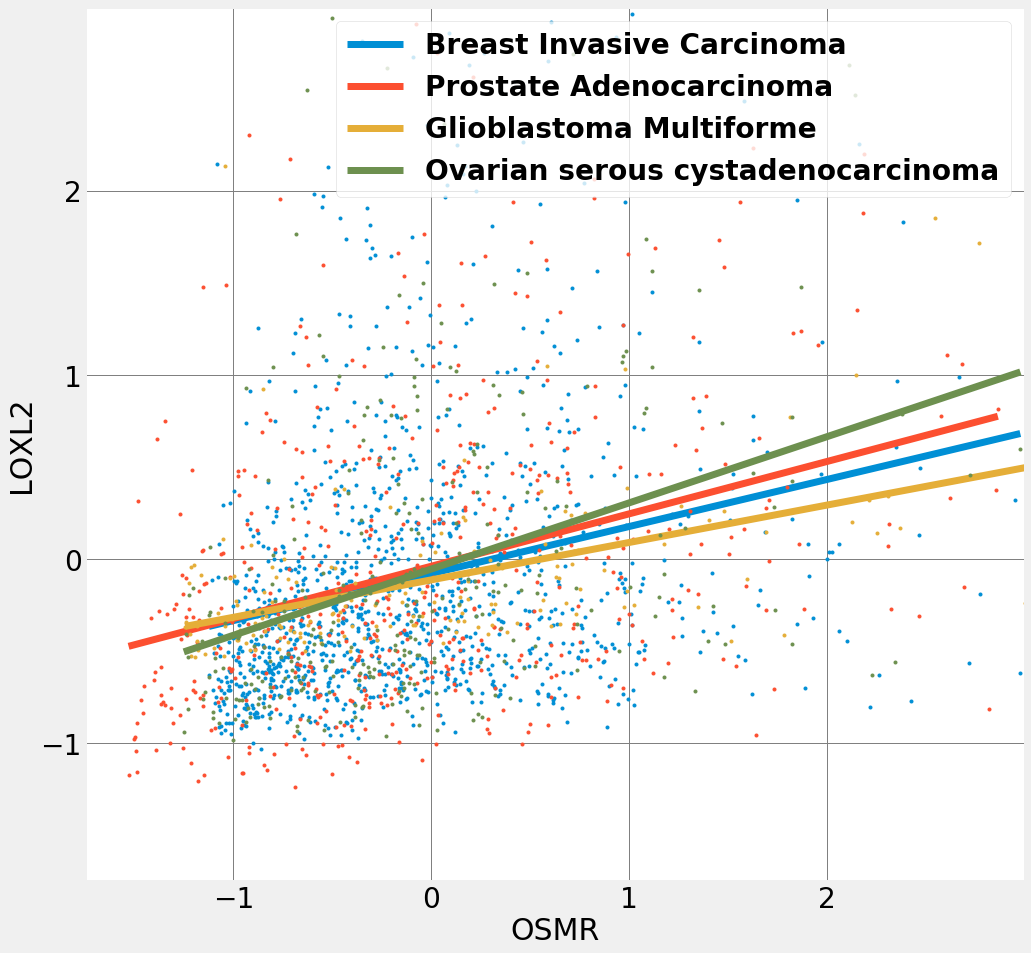

In [27]:
def get_df_name(df):
    """A brief function to get the name of the dataframe being used in the for loop below
    so that we can label the graph as needed."""
    
    name =[x for x in globals() if globals()[x] is df][0]
    return name

datasets = [brca_tcga_gene_normalized,prda_tcga_gene_normalized,gbm_tcga_gene_normalized,ov_tcga_gene_normalized]

gene_of_interest_x = 'OSMR'
gene_of_interest_y = 'LOXL2'

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in datasets:
    #Script to get DF name
    name = get_df_name(i)
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == "brca_tcga_gene_normalized":
        data_name = "Breast Invasive Carcinoma"
    if name == "prda_tcga_gene_normalized":
        data_name = "Prostate Adenocarcinoma"
    if name == "gbm_tcga_gene_normalized":
        data_name = "Glioblastoma Multiforme"
    if name == "ov_tcga_gene_normalized":
        data_name = "Ovarian serous cystadenocarcinoma"
    
    #Next, i'm running my gene selection
    x = (i['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    i['genelist'] = x
        
    gene_selectx = i.loc[i['genelist'] == gene_of_interest_x]
    gene_selecty = i.loc[i['genelist'] == gene_of_interest_y]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())

    
plt.tick_params(labelsize=28)
plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/TCGA_dataset_osmr_v_loxl2.png')
plt.show()


# No Legend as requested by Sim

Samples 1169
Patient count 1059
Breast Invasive Carcinoma Pearson Coefficient: (0.26256193825853363, 6.966323222116979e-20)
[-0.07907891  0.25537208]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     86.41
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           6.97e-20
Time:                        13:29:41   Log-Likelihood:                -1195.8
No. Observations:                1169   AIC:                             2396.
Df Residuals:                    1167   BIC:                             2406.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      

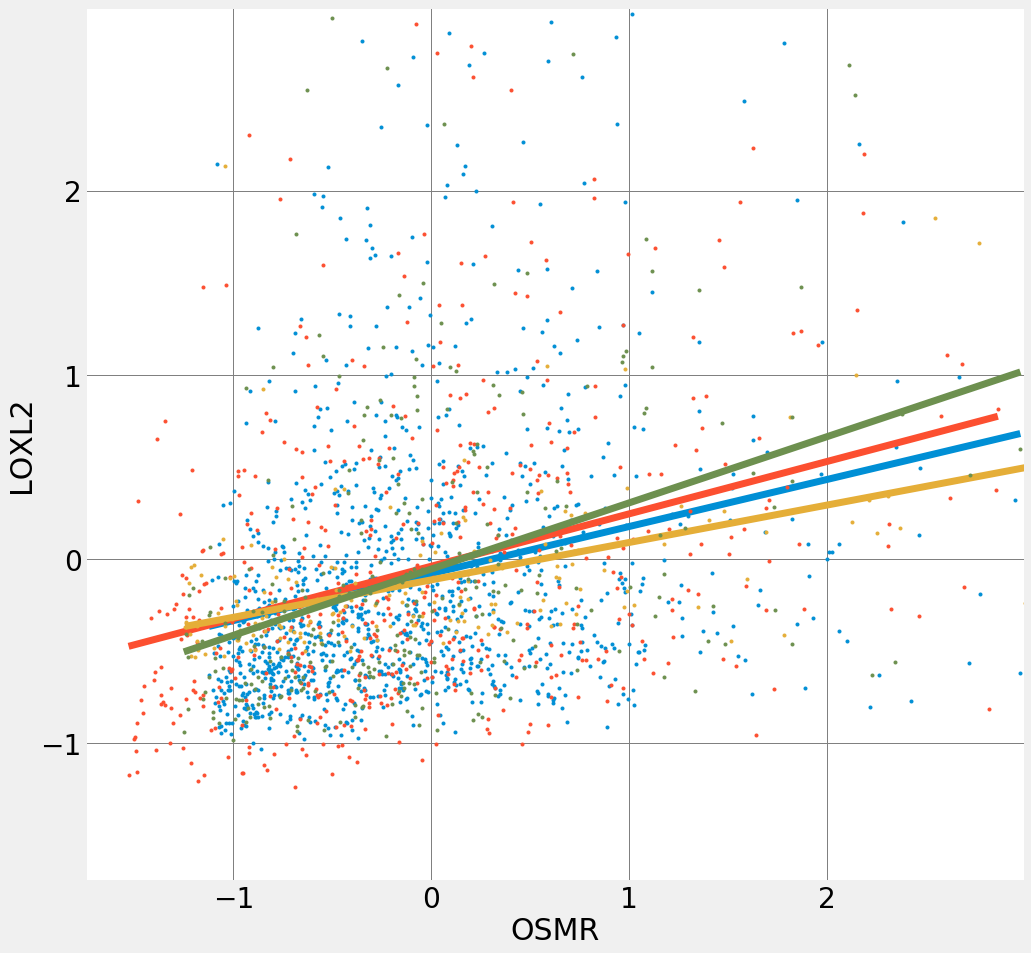

In [28]:
def get_df_name(df):
    """A brief function to get the name of the dataframe being used in the for loop below
    so that we can label the graph as needed."""
    
    name =[x for x in globals() if globals()[x] is df][0]
    return name

datasets = [brca_tcga_gene_normalized,prda_tcga_gene_normalized,gbm_tcga_gene_normalized,ov_tcga_gene_normalized]

gene_of_interest_x = 'OSMR'
gene_of_interest_y = 'LOXL2'

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in datasets:
    #Script to get DF name
    name = get_df_name(i)
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == "brca_tcga_gene_normalized":
        data_name = "Breast Invasive Carcinoma"
    if name == "prda_tcga_gene_normalized":
        data_name = "Prostate Adenocarcinoma"
    if name == "gbm_tcga_gene_normalized":
        data_name = "Glioblastoma Multiforme"
    if name == "ov_tcga_gene_normalized":
        data_name = "Ovarian serous cystadenocarcinoma"
    
    #Next, i'm running my gene selection
    x = (i['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    i['genelist'] = x
        
    gene_selectx = i.loc[i['genelist'] == gene_of_interest_x]
    gene_selecty = i.loc[i['genelist'] == gene_of_interest_y]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())

    
plt.tick_params(labelsize=28)
#plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/TCGA_dataset_osmr_v_loxl2_nolegend.png')
plt.show()


Next, we want to look at OSM / OSMR correlation with LOX family members in the breast cancer dataset.

Samples 1169
Patient count 1062
LOX Pearson Coefficient: (0.4626611174001444, 4.601696051189719e-63)
[-0.04383803  0.4923359 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     317.8
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           4.60e-63
Time:                        13:29:51   Log-Likelihood:                -1218.4
No. Observations:                1169   AIC:                             2441.
Df Residuals:                    1167   BIC:                             2451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

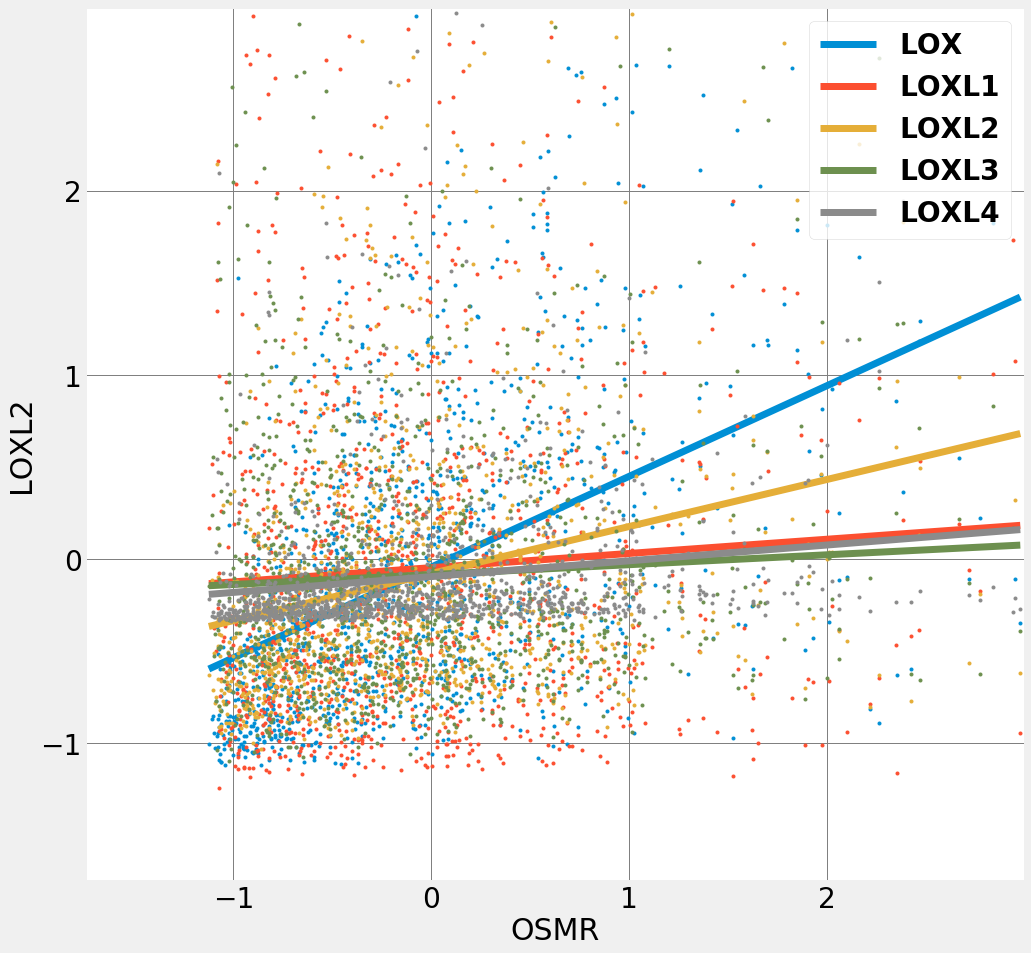

In [29]:
gene_of_interest_x = 'OSMR'
genes_for_y_run = ['LOX','LOXL1','LOXL2','LOXL3','LOXL4']

plt.figure(figsize=(15,15))

ax = plt.gca(facecolor='white')
for i in genes_for_y_run:
    #Script to get DF name
    name = i
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == 'LOX':
        data_name = "LOX"
    if name == 'LOXL1':
        data_name = "LOXL1"
    if name == "LOXL2":
        data_name = "LOXL2"
    if name == "LOXL3":
        data_name = "LOXL3"
    if name == "LOXL4":
        data_name = "LOXL4"
    
    
    
    #Next, i'm running my gene selection
    x = (brca_tcga_gene_normalized['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    brca_tcga_gene_normalized['genelist'] = x
        
    gene_selectx = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == gene_of_interest_x]
    gene_selecty = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == i]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())

    
plt.tick_params(labelsize=28)
plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/BRCA_dataset_osmr_v_loxfamily.png', facecolor=('white'))
plt.show()


#No Legend as requested by Sim 

Samples 1169
Patient count 1062
LOX Pearson Coefficient: (0.4626611174001444, 4.601696051189719e-63)
[-0.04383803  0.4923359 ]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     317.8
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           4.60e-63
Time:                        13:30:01   Log-Likelihood:                -1218.4
No. Observations:                1169   AIC:                             2441.
Df Residuals:                    1167   BIC:                             2451.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

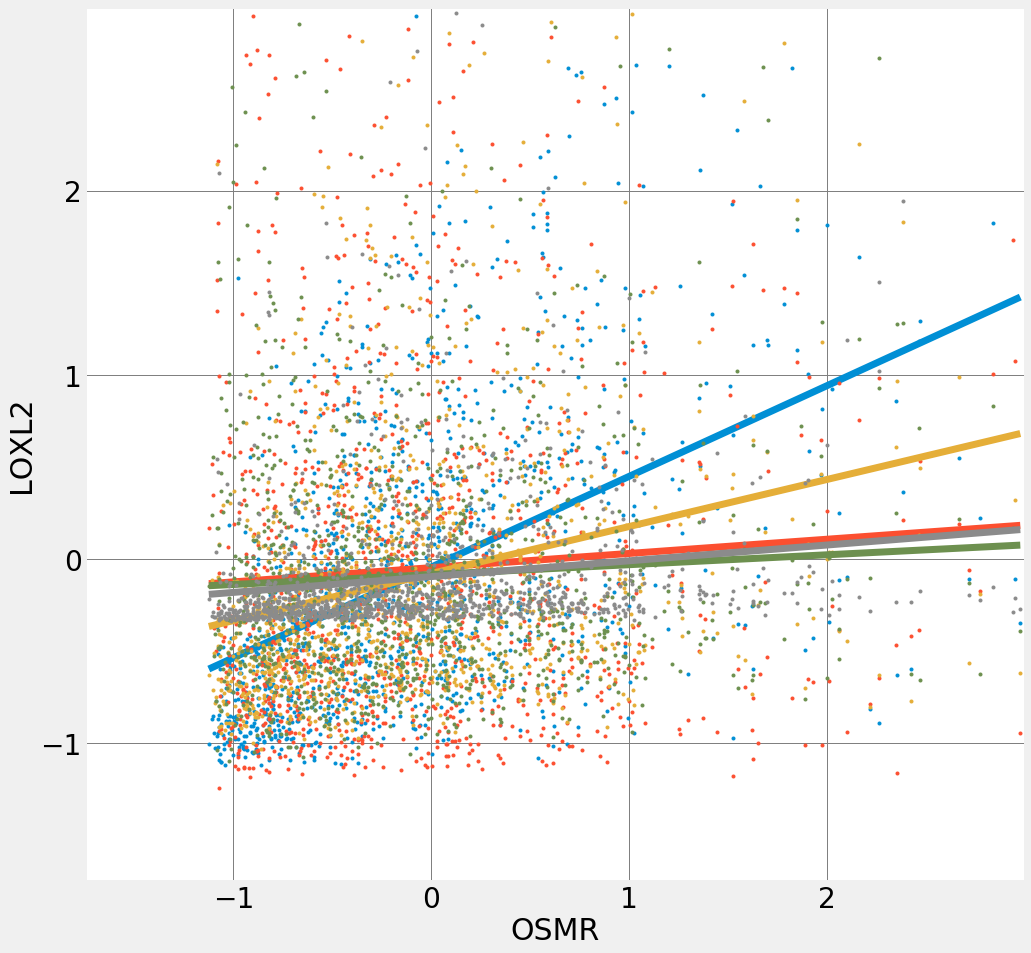

In [30]:
gene_of_interest_x = 'OSMR'
genes_for_y_run = ['LOX','LOXL1','LOXL2','LOXL3','LOXL4']

plt.figure(figsize=(15,15))

ax = plt.gca(facecolor='white')
for i in genes_for_y_run:
    #Script to get DF name
    name = i
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == 'LOX':
        data_name = "LOX"
    if name == 'LOXL1':
        data_name = "LOXL1"
    if name == "LOXL2":
        data_name = "LOXL2"
    if name == "LOXL3":
        data_name = "LOXL3"
    if name == "LOXL4":
        data_name = "LOXL4"
    
    
    
    #Next, i'm running my gene selection
    x = (brca_tcga_gene_normalized['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    brca_tcga_gene_normalized['genelist'] = x
        
    gene_selectx = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == gene_of_interest_x]
    gene_selecty = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == i]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())

    
plt.tick_params(labelsize=28)
#plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 2.5, 1))
plt.axis([-1.75, 3, -1.75, 3])
plt.xticks(np.arange(-1, 2.5, 1))
plt.savefig('figures/BRCA_dataset_osmr_v_loxfamily_nolegend.png', facecolor=('white'))
plt.show()


Samples 1159
Patient count 1048
LOX Pearson Coefficient: (0.14964159306768487, 3.0919217928802857e-07)
Y =  0.16608746908284655 X -0.07182326300694354
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     26.50
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           3.09e-07
Time:                        13:45:27   Log-Likelihood:                -1337.5
No. Observations:                1159   AIC:                             2679.
Df Residuals:                    1157   BIC:                             2689.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

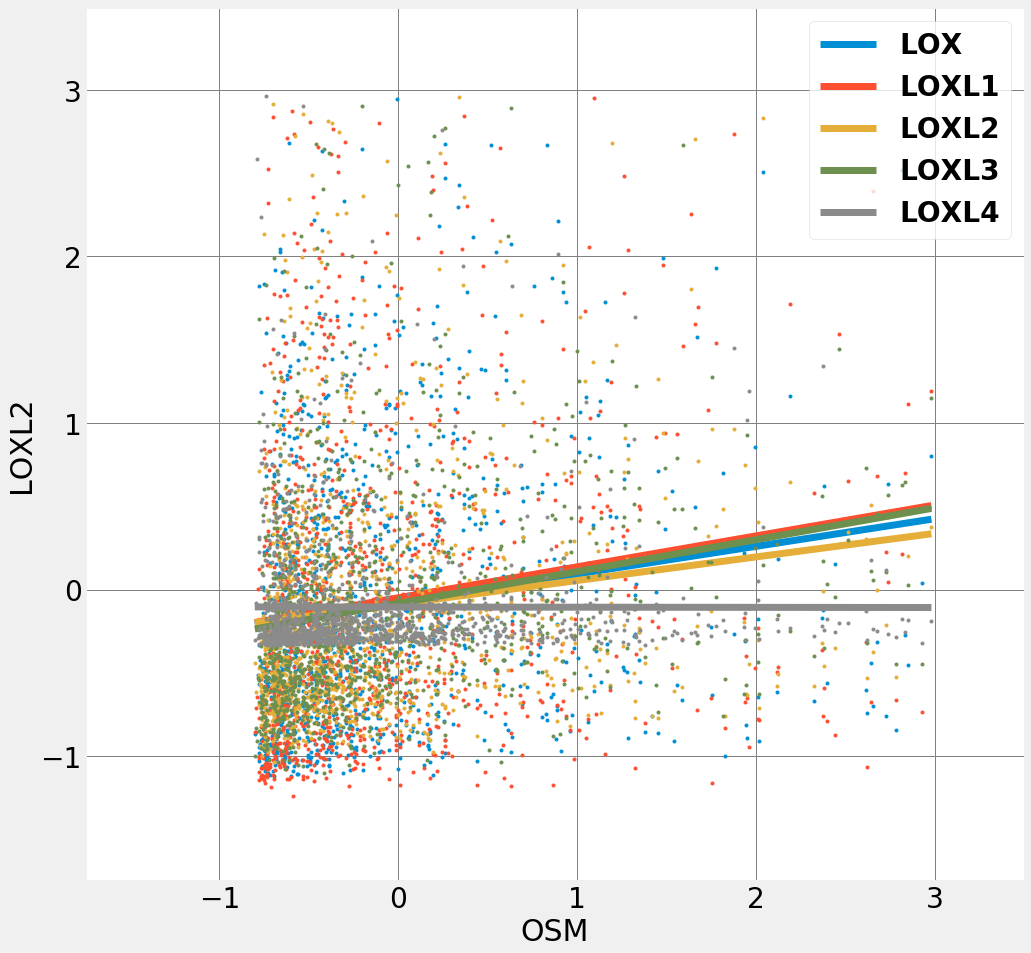

In [47]:
gene_of_interest_x = 'OSM'
genes_for_y_run = ['LOX','LOXL1','LOXL2','LOXL3','LOXL4']

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in genes_for_y_run:
    #Script to get DF name
    name = i
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == 'LOX':
        data_name = "LOX"
    if name == 'LOXL1':
        data_name = "LOXL1"
    if name == "LOXL2":
        data_name = "LOXL2"
    if name == "LOXL3":
        data_name = "LOXL3"
    if name == "LOXL4":
        data_name = "LOXL4"
    
    
    
    #Next, i'm running my gene selection
    x = (brca_tcga_gene_normalized['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    brca_tcga_gene_normalized['genelist'] = x
        
    gene_selectx = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == gene_of_interest_x]
    gene_selecty = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == i]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())
    
plt.tick_params(labelsize=28)
plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 3.5, 1))
plt.axis([-1.75, 3.5, -1.75, 3.5])
plt.xticks(np.arange(-1, 3.5, 1))
plt.savefig('figures/BRCA_dataset_osm_v_loxfamily.png')
plt.show()


# No legend as requested by Sim

Samples 1159
Patient count 1048
LOX Pearson Coefficient: (0.14964159306768487, 3.0919217928802857e-07)
Y =  0.16608746908284655 X -0.07182326300694354
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     26.50
Date:                Mon, 01 Jun 2020   Prob (F-statistic):           3.09e-07
Time:                        13:46:02   Log-Likelihood:                -1337.5
No. Observations:                1159   AIC:                             2679.
Df Residuals:                    1157   BIC:                             2689.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

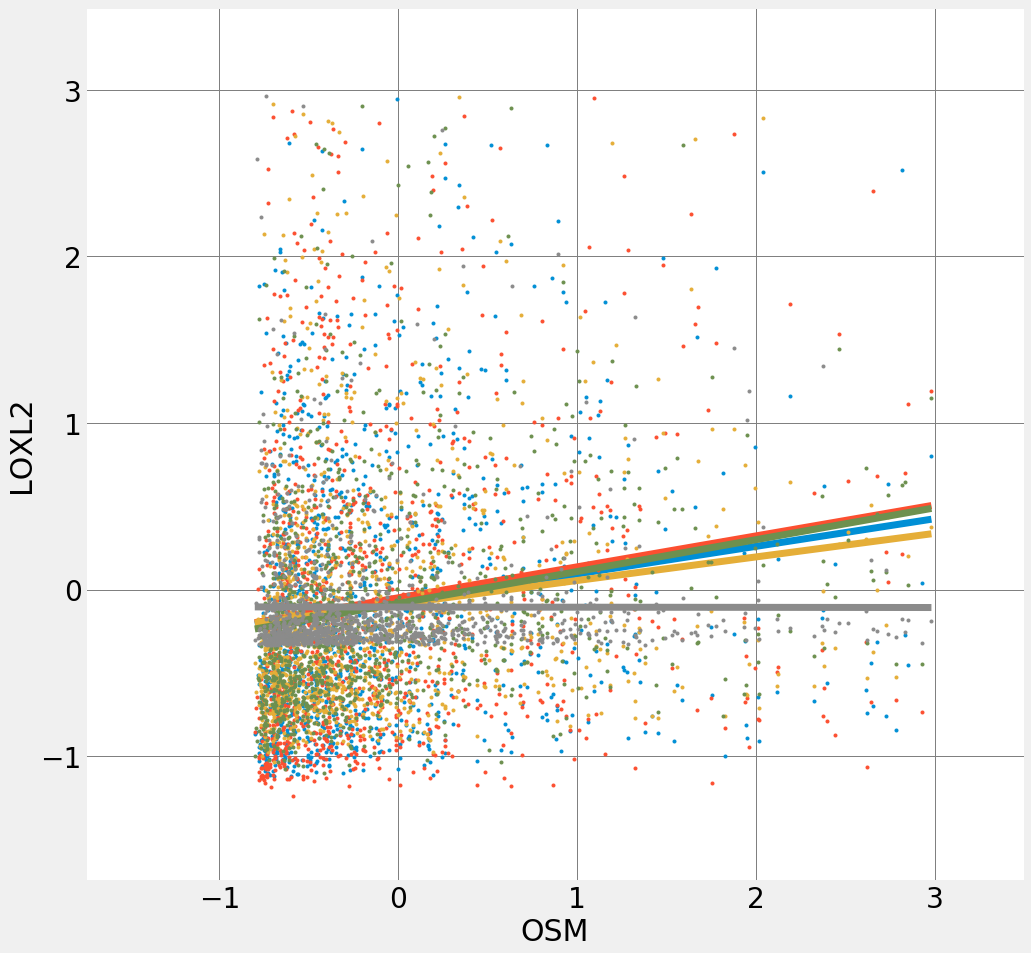

In [48]:
gene_of_interest_x = 'OSM'
genes_for_y_run = ['LOX','LOXL1','LOXL2','LOXL3','LOXL4']

plt.figure(figsize=(15,15))

ax = plt.gca()
for i in genes_for_y_run:
    #Script to get DF name
    name = i
    #I want to give these a specific name, so I'll call a variable based on the dataset name:
    if name == 'LOX':
        data_name = "LOX"
    if name == 'LOXL1':
        data_name = "LOXL1"
    if name == "LOXL2":
        data_name = "LOXL2"
    if name == "LOXL3":
        data_name = "LOXL3"
    if name == "LOXL4":
        data_name = "LOXL4"
    
    
    
    #Next, i'm running my gene selection
    x = (brca_tcga_gene_normalized['Hybridization REF'].str.split("|", n = 1, expand = True)[0])
    brca_tcga_gene_normalized['genelist'] = x
        
    gene_selectx = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == gene_of_interest_x]
    gene_selecty = brca_tcga_gene_normalized.loc[brca_tcga_gene_normalized['genelist'] == i]
    genes = gene_selectx.append(gene_selecty)

#Formating X gene into a list for plotting
    genes_numeric = genes.drop(['Hybridization REF', 'genelist'], axis=1)
    genes_numeric = genes_numeric.astype('float64', copy=True, errors='raise')
    zgenes_numeric = genes_numeric.apply(stats.zscore, axis=1,result_type='broadcast')

#Now, I need to remove outliers. So any column that has a z score of great than 3 we expect is an outlier and will filter those.
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    zgenes_numeric = zgenes_numeric[zgenes_numeric.columns[zgenes_numeric.max() < 3]]
    col_name = []
    for col in zgenes_numeric: 
        col_name.append(col)
    clean_names = []
    for i in col_name:
        x = i[8:-16]
        clean_names.append(x)
    print ("Samples",(len(clean_names)))
    pat_samples = list(dict.fromkeys(clean_names))
    print ("Patient count",(len(pat_samples)))
    
#Converting the lists for use in the scatterplot
    arrayx = zgenes_numeric[0:1]
    arrayy = zgenes_numeric[1:2]
    
    #listx = np.asarray(arrayx)
    #listy = np.asarray(arrayy)
    
    
    listx = np.asarray((arrayx.values.tolist())[0])
    listy = np.asarray((arrayy.values.tolist())[0])
    

#Plotting the scatterplot
    x = listx
    y = listy

    x = smf.add_constant(x) # constant intercept term
# Model: y ~ x + c

    model = smf.OLS(y, x)

    fitted = model.fit()

    x_pred = np.linspace(x.min(), x.max(), 50)

    x_pred2 = smf.add_constant(x_pred)

    y_pred = fitted.predict(x_pred2)
    
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(listx, listy, '.', color = color)
    plt.plot(x_pred, y_pred, '-', label=data_name, color = color, linewidth=7)
    
    #plt.title(gene_of_interest_x,'vs', gene_of_interest_y)
    plt.xlabel(gene_of_interest_x, fontsize=30)
    plt.ylabel(gene_of_interest_y, fontsize=30)
    

    test = zgenes_numeric.to_numpy()
    pearsonx = test[0]
    pearsony = test[1]
    pearsonvalue = pearsonr(pearsonx,pearsony)
    print (data_name,"Pearson Coefficient:", pearsonvalue)
    print('Y = ',fitted.params[1],'X',fitted.params[0])     # the estimated parameters for the regression line
    print(fitted.summary())

plt.tick_params(labelsize=28)
#plt.legend(loc='upper right', prop={'size': 28, 'weight':'bold'})
#Set the grid to grey
plt.grid(color='grey', mfc='grey')
plt.yticks(np.arange(-1, 3.5, 1))
plt.axis([-1.75, 3.5, -1.75, 3.5])
plt.xticks(np.arange(-1, 3.5, 1))
plt.savefig('figures/BRCA_dataset_osm_v_loxfamily_nolegend.png')
plt.show()
